In [1]:
import orbitize
from orbitize import driver
import matplotlib.pyplot as plt
import multiprocessing as mp
import warnings
warnings.filterwarnings("ignore")

In [2]:
mp.cpu_count()

12

In [2]:
import matplotlib.pyplot as plt

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
import pandas as pd
import numpy as np

results = pd.read_csv(
    'thesis_allast.csv',
    header = 0,
    sep = ','
)

In [ ]:
# for orvara
import datetime
results['datetime'] = [datetime.datetime.strptime(x, '%Y/%m/%d') for x in results['Date (year/month/day)']]
results['epoch'] = [(x-results.datetime[0]).days for x in results.datetime]
from astropy.time import Time
results['Date'] = [Time(x, format='datetime').decimalyear for x in results['datetime']]
results['source'] = [x.replace('Balmer','Balmer_in_prep') for x in results['Source']]

outtable = pd.DataFrame()
outtable['Date'] = results['Date']
outtable['Sep'] = results['Sep (mas)']/1000
outtable['Err_sep'] = results['Sep_err']/1000
outtable['PA'] = results['PA (deg)']
outtable['Err_PA'] = results['PA_err']
outtable['Sep_PA_corr'] = np.zeros_like(len(results))
outtable['PlanetID'] = np.zeros_like(len(results))
outtable['source'] = results['Source']
outtable.to_csv('hd142-orvaralike-full.csv', index=False)
outtable.head()

In [4]:
import datetime
results['datetime'] = [datetime.datetime.strptime(x, '%Y/%m/%d') for x in results['Date (year/month/day)']]
results['epoch'] = [(x-results.datetime[0]).days for x in results.datetime]
from astropy.time import Time
results['MJD'] = [Time(x, format='datetime').mjd for x in results['datetime']]

outtable = pd.DataFrame()
outtable['epoch'] = results['MJD']
outtable['object'] = np.ones(len(results), dtype=np.int8)
outtable['sep'] = results['Sep (mas)']
outtable['sep_err'] = results['Sep_err']
outtable['pa'] = results['PA (deg)']
outtable['pa_err'] = results['PA_err']
outtable.to_csv('hd142-allast-orbitizelike.csv', index=False)
outtable['inst'] = results['Instrument']
outtable['source'] = results['Source']
outtable['wavelength'] = results['Wavelength']
outtable['method'] = results['Method']
outtable.to_csv('hd142-allast-full.csv', index=False)

In [5]:
# MCMC parameters
num_walkers = 16
num_threads = int(mp.cpu_count()*(2/3)) # or a different number if you prefer

my_driver = orbitize.driver.Driver('hd142-allast-orbitizelike.csv', # path to data file
                                  'MCMC', # name of algorithm for orbit-fitting
                                  1, # number of secondary bodies in system
                                  2.25, # total system mass [M_sun]
                                  6.35606723729484, # total parallax of system [mas]
                                  mass_err=0.5, # mass error [M_sun]
                                  plx_err=0.04714455423, # parallax error [mas]
                                  mcmc_kwargs={'num_walkers': num_walkers, 'num_threads': num_threads})

In [36]:
# RUN MCMC
total_orbits = int(num_walkers*5e5) # number of steps x number of walkers (at lowest temperature)
burn_steps = int(1e5) # steps to burn in per walker
thin = 2 # only save every 2nd step

my_driver.sampler.run_sampler(total_orbits, burn_steps=burn_steps, thin=thin)

Starting Burn in
100000/100000 steps of burn-in complete
Burn in complete. Sampling posterior now.
500000/500000 steps completed
Run complete


<Figure size 1008x432 with 0 Axes>

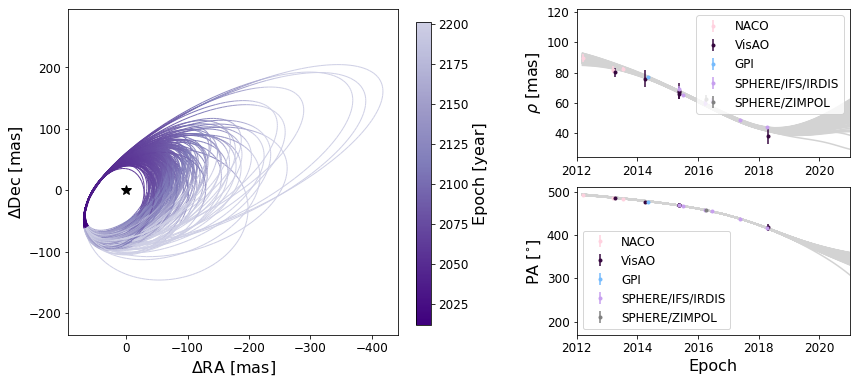

In [49]:
orb_fig = my_driver.sampler.results.plot_orbits(
    object_to_plot = 1, # Plot orbits for the first (and only, in this case) companion
    num_orbits_to_plot= 200, # Will plot 100 randomly selected orbits of this companion
    start_mjd=epochs[0], # Minimum MJD for colorbar (here we choose first data epoch)
    plot_astrometry=False,
    data = my_driver.system.data_table,
    mod180=True
)

ax_orb, ax_sep, ax_pa, ax_cbar  = orb_fig.axes
c = 0
for inst in insts:
    data_tab = instdict[inst]
    color = colors[c]
    c += 1
    # add data to sep panel
    ax_sep.errorbar(
        data_tab['yr'], data_tab['sep'], data_tab['sep_err'],
        color=color, 
        linestyle='', fmt='o', zorder=3, label=inst, markersize=3
    )

    # add data to PA panel
    ax_pa.errorbar(
        data_tab['yr'], data_tab['pa'], data_tab['pa_err'],
        color=color, 
        linestyle='', fmt='o', zorder=3, label=inst, markersize=3
    )

ax_orb.plot(0,0,marker="*",color='black',markersize=10)
ax_sep.legend()
ax_pa.legend()

# zoom in a bit
ax_sep.set_xlim(2012,2021)
ax_pa.set_xlim(2012,2021)
# ax_sep.set_ylim(113.5,118)
# ax_pa.set_ylim(221,231)

plt.savefig('hd142527Ball_orbit_plot.png', transparent=True, dpi=150) # This is matplotlib.figure.Figure.savefig()

In [37]:
# save result as hdf5
hdf5_filename='thesis_posterior.hdf5'
import os
# To avoid weird behaviours, delete saved file if it already exists from a previous run of this notebook
if os.path.isfile(hdf5_filename):
    os.remove(hdf5_filename)
my_driver.sampler.results.save_results(hdf5_filename)

In [6]:
# load in saved hdf5 result
hdf5_filename='paperdraft_posterior.hdf5'
from orbitize import results
loaded_results = results.Results() # Create blank results object for loading
loaded_results.load_results(hdf5_filename) 

(array([ 8525., 30452., 24286., 20362., 16451., 12820., 33037., 21951.,
        17906., 14210.]),
 array([2.14202587e-02, 3.60180782e+01, 7.20147362e+01, 1.08011394e+02,
        1.44008052e+02, 1.80004710e+02, 2.16001368e+02, 2.51998026e+02,
        2.87994684e+02, 3.23991342e+02, 3.59988000e+02]),
 <BarContainer object of 10 artists>)

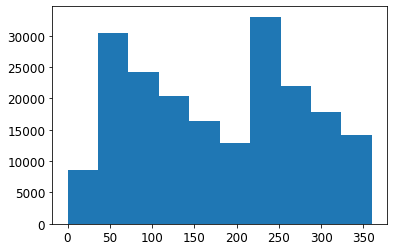

In [65]:
plt.hist(data[::,3])

In [66]:
data = loaded_results.post
# data[:,2] = np.rad2deg(data[:,2])
# data[:,3] = np.rad2deg(data[:,3])
# data[:,4] = np.rad2deg(data[:,4])
sma = data[:, 0]
ecc = data[:, 1]
inc = data[:, 2]
aop = data[:, 3]
pan = data[:, 4]
tau = data[:, 5]
mtot = data[:, 6]
plx = data[:, 7]
from scipy import stats
import pandas as pd

meds = []
errs = []
from astropy.stats import circmean, circvar
for i in range(len(data[0,:])):
    if i == 4:
        dist1 = data[data[:, i] > 180][:,i]
        dist2 = data[data[:, i] < 180][:,i]
        
        med1 = circmean(dist1)
        err1 = np.sqrt(circvar(dist1))

        med2 = circmean(dist2)
        err2 = np.sqrt(circvar(dist2))

        med = (med1,med2)
        err = (err1,err2)
    elif i == 3:
        dist1 = data[data[:, i] > 180][:,i]
        dist2 = data[data[:, i] < 180][:,i]
        
        med1 = circmean(dist1)
        err1 = np.sqrt(circvar(dist1))

        med2 = circmean(dist2)
        err2 = np.sqrt(circvar(dist2))

        med = (med1,med2)
        err = (err1,err2)
    
#     elif i == 5:
        
    
    else:
        dist = data[:,i]
        med = np.median(dist)#[0][0]
        err = np.std(dist)
    meds.append(med)
    errs.append(err)

orbitDF = pd.DataFrame(columns=['median','error'], index=['a','e','i','pan','aop','tau','plx','mtot'])
orbitDF['median'] = meds
orbitDF['error'] = errs

# orbitDF.loc['i'] = [np.rad2deg(x) for x in orbitDF.loc['i']]
orbitDF.loc['aop'] = [np.rad2deg(x) % 360 for x in orbitDF.loc['aop']]
orbitDF.loc['pan'] = [np.rad2deg(x) % 360 for x in orbitDF.loc['pan']]

orbitDF.to_clipboard()
orbitDF

,median,error
a,14.023203,5.68367
e,0.236005,0.152961
i,124.858291,4.564513
pan,"[322.4026257154103, 142.38381608087658]","[56.987719483211656, 56.93082830853033]"
aop,"[58.63077945438616, 225.2224006914206]","[56.20979340993885, 56.36387374388494]"
tau,0.919073,0.426754
plx,6.358748,0.046264
mtot,2.661672,0.386857


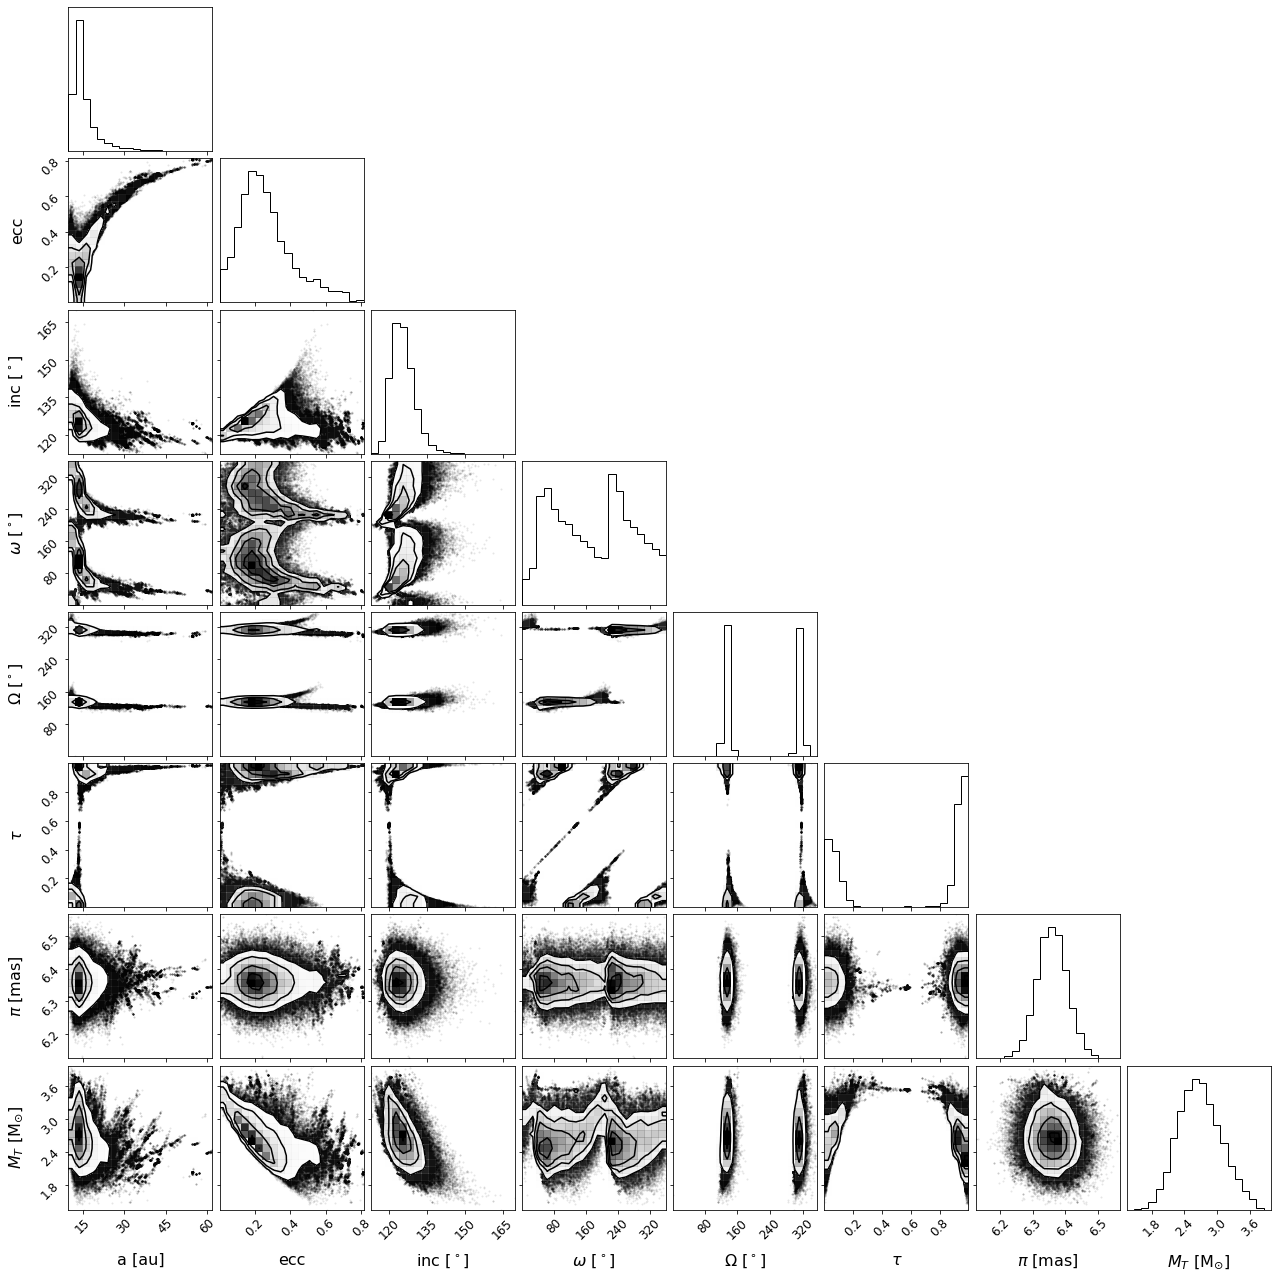

In [16]:
#MCMC PLOTS
corner_plot_fig = loaded_results.plot_corner(
#     range=[[0,60],[0,1],[100,180],[0,360],[80,360],[0,1],[6,6.6],[1.2,3.8]]
) # Creates a corner plot and returns Figure object
corner_plot_fig.savefig('hd142527B_full_corner_plot.png', dpi=300) # This is matplotlib.figure.Figure.savefig()

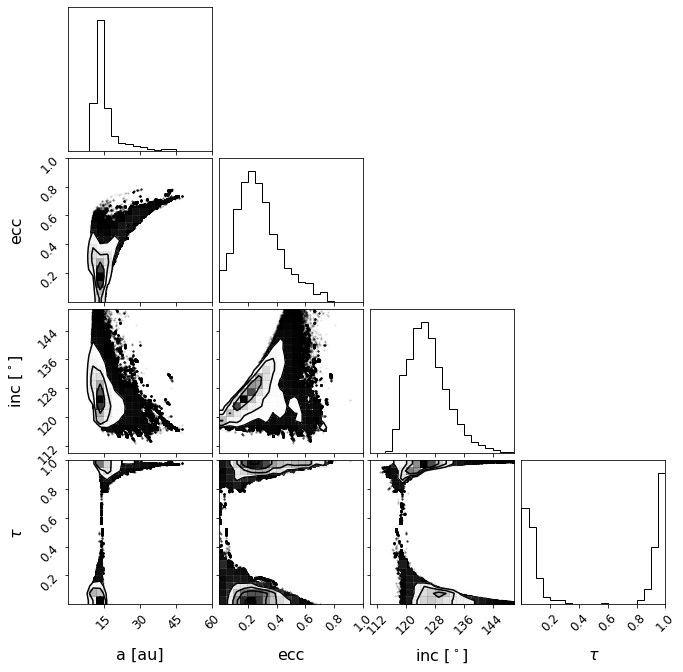

In [8]:
#MCMC PLOTS
corner_plot_fig = loaded_results.plot_corner(param_list=['sma1','ecc1','inc1', 'tau1'], range=[[0,60],[0,1],[110,150],[0,1]]) # Creates a corner plot and returns Figure object
corner_plot_fig.savefig('hd142527B_all_small_corner_plot.png', transparent=True, dpi=300) # This is matplotlib.figure.Figure.savefig()

In [17]:
colors = ['#ef473a', '#30122d', '#870734', '#cb2d3e', '#ffd6bf']

In [7]:
colors = ['grey', 'xkcd:burnt orange', 'grey', 'grey', 'grey']

In [22]:
symbols = ['v','o','s','x','p']

In [23]:
from astropy.time import Time
epochs = my_driver.system.data_table['epoch']
epochs_yr = Time(epochs, format='mjd').decimalyear
# grab data from Driver object
data_tab = outtable
data_tab['yr'] = epochs_yr
data_tab['pa'][data_tab['pa'] < 180] += 360
data_tab['ra'], data_tab['dec'] = orbitize.system.seppa2radec(data_tab['sep'], data_tab['pa'])
data_tab['ra_err'] = np.sqrt((data_tab['pa_err']/data_tab['pa'])**2 + (data_tab['sep_err']/data_tab['sep'])**2)*data_tab['ra']
data_tab['dec_err'] = np.sqrt((data_tab['pa_err']/data_tab['pa'])**2 + (data_tab['sep_err']/data_tab['sep'])**2)*data_tab['dec']


insts = []
for inst in data_tab['inst']:
    if inst not in insts:
        insts.append(inst)
instdict = {}
symboldict = {}
sym = 0
for inst in insts:
    inds = []
    for i in data_tab.index:
        if inst == data_tab['inst'].iloc[i]:
            inds.append(i)
    print(inst, inds)
    instdict[inst] = data_tab.iloc[inds]
    symboldict[inst] = symbols[sym]
    sym += 1
    

NACO [0, 1, 3]
VisAO [2, 4, 8, 9, 10, 17]
GPI [5, 6]
SPHERE/IFS/IRDIS [7, 11, 12, 14, 15, 16]
SPHERE/ZIMPOL [13]


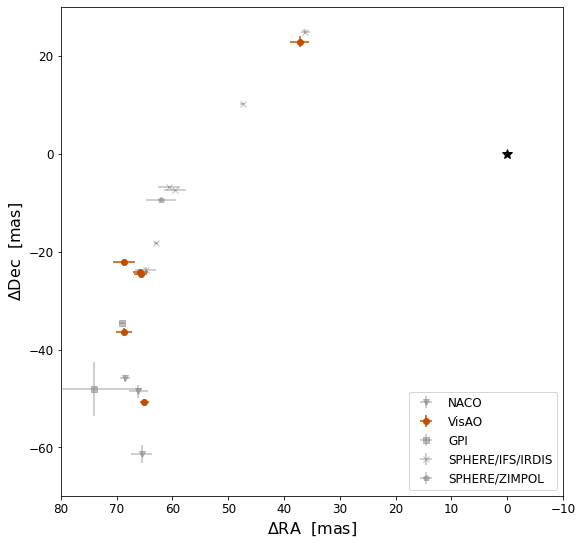

In [26]:
epochs = my_driver.system.data_table['epoch']
c = 0
fig = plt.figure(figsize=(9,9))
for inst in insts:
    if inst == 'VisAO':
        alpha = 1
    else:
        alpha = 0.5
    data_tab = instdict[inst]
    color = colors[c]
    symbol = symbols[c]
    c += 1
    # add RA/Dec to orb panel
    plt.errorbar(
        data_tab['ra'], data_tab['dec'], xerr=data_tab['ra_err'], yerr=data_tab['dec_err'],
        color=color, linestyle='', marker=symbol, zorder=3, label=inst, markersize=6, alpha=alpha
    )
plt.plot(0,0,marker="*",color='black',markersize=10)
plt.xlim(80,-10)
plt.ylim(-70,30)
plt.legend(loc='lower right')
plt.xlabel(r'$\Delta$RA  [mas]')
plt.ylabel(r'$\Delta$Dec  [mas]')

plt.savefig('HD142527_B_astrometry.png',dpi=300)

<Figure size 1008x432 with 0 Axes>

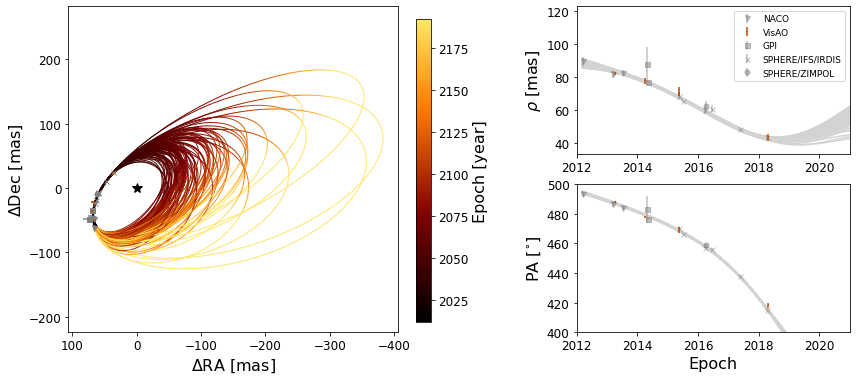

In [22]:
epochs = my_driver.system.data_table['epoch']

orbit_plot_fig = loaded_results.plot_orbits(
    object_to_plot = 1, # Plot orbits for the first (and only, in this case) companion
    num_orbits_to_plot = 100, # Will plot 100 randomly selected orbits of this companion
    start_mjd=epochs[0], # Minimum MJD for colorbar (here we choose first data epoch)
    plot_astrometry=False,
    data = my_driver.system.data_table,
    mod180=True
)

ax_orb, ax_sep, ax_pa, ax_cbar  = orbit_plot_fig.axes
c = 0
for inst in insts:
    data_tab = instdict[inst]
    if inst == 'VisAO':
        alpha = 1
        zorder = 10
    else:
        alpha = 0.5
        zorder = 3
    color = colors[c]
    symbol = symbols[c]
    c += 1
    # add data to sep panel
    ax_sep.errorbar(
        data_tab['yr'], data_tab['sep'], data_tab['sep_err'],
        color=color, 
        linestyle='', marker=symbol, label=inst, markersize=5, alpha=alpha, zorder=zorder
    )

    # add data to PA panel
    ax_pa.errorbar(
        data_tab['yr'], data_tab['pa'], data_tab['pa_err'],
        color=color, 
        linestyle='', marker=symbol, label=inst, markersize=5, alpha=alpha, zorder=zorder
    )
    
    # add RA/Dec to orb panel
    ax_orb.errorbar(
        data_tab['ra'], data_tab['dec'], xerr=data_tab['ra_err'], yerr=data_tab['dec_err'],
        color=color, linestyle='', marker=symbol, label=inst, markersize=5, alpha=1, zorder=zorder
    )

ax_orb.plot(0,0,marker="*",color='black',markersize=10)
# ax_sep.legend()
# ax_pa.legend()

ax_sep.legend(#borderaxespad=0.1,    # Small spacing around legend box
           prop={'size': 9}
           )

# zoom in a bit
ax_sep.set_xlim(2012,2021)
ax_pa.set_xlim(2012,2021)
# ax_sep.set_ylim(113.5,118)
ax_pa.set_ylim(400,500)

plt.savefig('hd142527B_all_orbit_plot.png', transparent=True, dpi=300) # This is matplotlib.figure.Figure.savefig()

In [132]:
import corner
import numpy as np
# load in saved hdf5 result
hdf5_filename='thesis_posterior.hdf5'
from orbitize import results
loaded_results = results.Results() # Create blank results object for loading
loaded_results.load_results(hdf5_filename) 

tau1post = loaded_results.post
tau1post = tau1post[tau1post[:, 5] > 0.5]

<Figure size 1008x432 with 0 Axes>

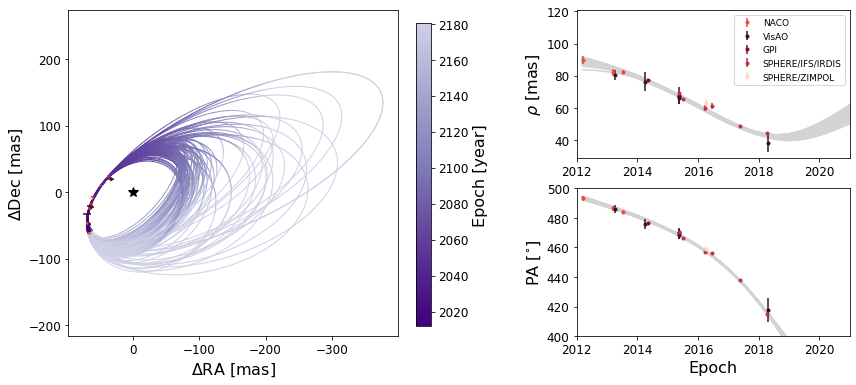

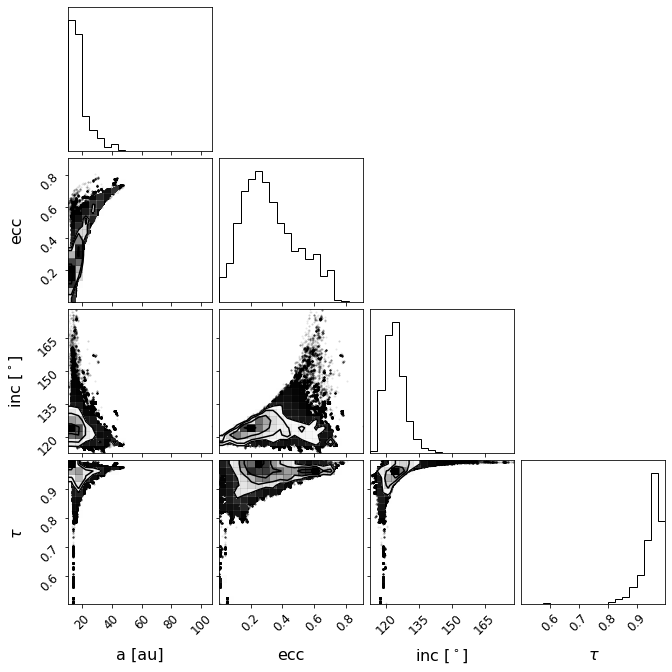

In [93]:
orbfam1 = loaded_results.plot_orbits(
    object_to_plot = 1, # Plot orbits for the first (and only, in this case) companion
    num_orbits_to_plot= 100, # Will plot 100 randomly selected orbits of this companion
    start_mjd=epochs[0], # Minimum MJD for colorbar (here we choose first data epoch)
    plot_astrometry=False,
    data = my_driver.system.data_table,
    mod180=True,
    post=tau1post
)

ax_orb, ax_sep, ax_pa, ax_cbar  = orbfam1.axes
c = 0
for inst in insts:
    data_tab = instdict[inst]
    color = colors[c]
    c += 1
    # add data to sep panel
    ax_sep.errorbar(
        data_tab['yr'], data_tab['sep'], data_tab['sep_err'],
        color=color, 
        linestyle='', fmt='o', zorder=3, label=inst, markersize=3
    )

    # add data to PA panel
    ax_pa.errorbar(
        data_tab['yr'], data_tab['pa'], data_tab['pa_err'],
        color=color, 
        linestyle='', fmt='o', zorder=3, label=inst, markersize=3
    )
    
    # add RA/Dec to orb panel
    ax_orb.errorbar(
        data_tab['ra'], data_tab['dec'], xerr=data_tab['ra_err'], yerr=data_tab['dec_err'],
        color=color, linestyle='', fmt='.', zorder=3, label=inst, markersize=3
    )

ax_orb.plot(0,0,marker="*",color='black',markersize=10)
# ax_sep.legend()
# ax_pa.legend()

ax_sep.legend(#borderaxespad=0.1,    # Small spacing around legend box
           prop={'size': 9}
           )

# zoom in a bit
ax_sep.set_xlim(2012,2021)
ax_pa.set_xlim(2012,2021)
# ax_sep.set_ylim(113.5,118)
ax_pa.set_ylim(400,500)

plt.savefig('hd142527B_all_orbit_plot_TAU1.png', transparent=True, dpi=300) # This is matplotlib.figure.Figure.savefig()


cornerfam1 = loaded_results.plot_corner(param_list=['sma1','ecc1','inc1', 'tau1'])
cornerfam1.savefig('hd142527_B_all_small_corner_plot_TAU1.png', transparent=True, dpi=300)

In [133]:
import corner
import numpy as np
# load in saved hdf5 result
hdf5_filename='thesis_posterior.hdf5'
from orbitize import results
loaded_results = results.Results() # Create blank results object for loading
loaded_results.load_results(hdf5_filename) 

tau2post = loaded_results.post
tau2post = tau2post[tau2post[:, 5] < 0.5]

<Figure size 1008x432 with 0 Axes>

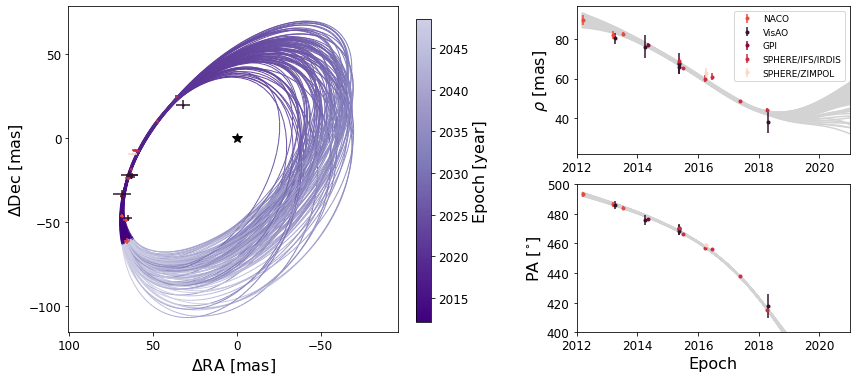

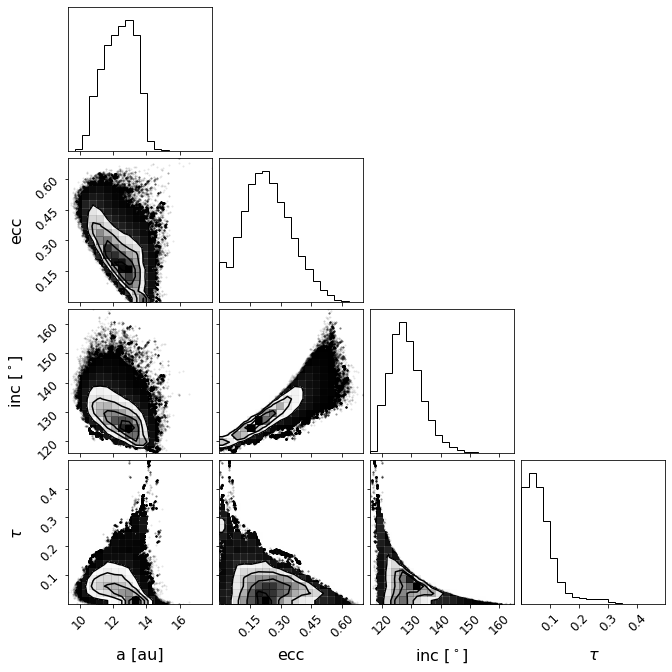

In [94]:
orbfam2 = loaded_results.plot_orbits(
    object_to_plot = 1, # Plot orbits for the first (and only, in this case) companion
    num_orbits_to_plot= 100, # Will plot 100 randomly selected orbits of this companion
    start_mjd=epochs[0], # Minimum MJD for colorbar (here we choose first data epoch)
    plot_astrometry=False,
    data = my_driver.system.data_table,
    mod180=True,
    post=tau2post
)

ax_orb, ax_sep, ax_pa, ax_cbar  = orbfam2.axes
c = 0
for inst in insts:
    data_tab = instdict[inst]
    color = colors[c]
    c += 1
    # add data to sep panel
    ax_sep.errorbar(
        data_tab['yr'], data_tab['sep'], data_tab['sep_err'],
        color=color, 
        linestyle='', fmt='o', zorder=3, label=inst, markersize=3
    )

    # add data to PA panel
    ax_pa.errorbar(
        data_tab['yr'], data_tab['pa'], data_tab['pa_err'],
        color=color, 
        linestyle='', fmt='o', zorder=3, label=inst, markersize=3
    )
    
    # add RA/Dec to orb panel
    ax_orb.errorbar(
        data_tab['ra'], data_tab['dec'], xerr=data_tab['ra_err'], yerr=data_tab['dec_err'],
        color=color, linestyle='', fmt='.', zorder=3, label=inst, markersize=3
    )

ax_orb.plot(0,0,marker="*",color='black',markersize=10)
# ax_sep.legend()
# ax_pa.legend()

ax_sep.legend(#borderaxespad=0.1,    # Small spacing around legend box
           prop={'size': 9}
           )

# zoom in a bit
ax_sep.set_xlim(2012,2021)
ax_pa.set_xlim(2012,2021)
# ax_sep.set_ylim(113.5,118)
ax_pa.set_ylim(400,500)

plt.savefig('hd142527B_all_orbit_plot_TAU2.png', transparent=True, dpi=300)

cornerfam2 = loaded_results.plot_corner(param_list=['sma1','ecc1','inc1', 'tau1'])
cornerfam2.savefig('hd142527_B_all_small_corner_plot_TAU2.png', transparent=True, dpi=300)

In [104]:
# sma = data[:, 0]
# ecc = data[:, 1]
# inc = data[:, 2]
# aop = data[:, 3]
# pan = data[:, 4]
# tau = data[:, 5]
# mtot = data[:, 7]
# plx = data[:, 6]
from scipy import stats

8

In [160]:
post = loaded_results.post
results = pd.DataFrame(index=range(len(post[0,:])), columns=['med','err1','err2'])
for i in range(len(post[0,:])):    
    mode = np.median(post[:, i])#[0][0]
    percens = np.percentile(post[:, i], [16, 84])
    if i in [2,3,4]:
        med, errs = np.degrees(round(mode,2)), np.degrees(np.round(percens,2)-round(mode,2))
    elif i == 5:
        import orbitize.basis
        tau_ref_epoch = 58849
        sma = post[:, 0]
        mtot = post[:, 7]
        period = np.sqrt(sma**3/mtot)
        tp = orbitize.basis.tau_to_tp(post[:, 5],tau_ref_epoch,period)
        mode = np.median(tp)#[0][0]
        percens = np.percentile(tp, [16, 84])
        mode = Time(mode, format='mjd').decimalyear
        percens = np.array([Time(x, format='mjd').decimalyear for x in percens])
        med, errs = round(mode,2), np.round(percens,2)-round(mode,2)
    else:
        med, errs = round(mode,2), np.round(percens,2)-round(mode,2)
    results.iloc[i]['med'] = med
    results.iloc[i]['err1'],results.iloc[i]['err2'] = errs
results.to_clipboard()

In [161]:
results.iloc[2]

med     125.477757
err1     -4.583662
err2      6.302536
Name: 2, dtype: object